In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import matplotlib.ticker as mticker

import seaborn
seaborn.set_context('talk')

from sqlalchemy import create_engine, text

**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2025*

----

# Trabajo práctico entregable - parte 1

En esta notebook, vamos a cargar el conjunto de datos de [la compentencia Kaggle](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot) sobre estimación de precios de ventas de propiedades en Melbourne, Australia.

Utilizaremos el conjunto de datos reducido producido por [DanB](https://www.kaggle.com/dansbecker). Hemos subido una copia a un servidor de la Universidad Nacional de Córdoba para facilitar su acceso remoto.

In [2]:
import plotly
plotly.__version__

'6.1.0'

In [3]:
# # data source: Melbourne 
melb_df = pd.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')

# data source: Airbnb-Melbourne
# https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv
interesting_cols = [
  'description', 'neighborhood_overview',
  'street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode',
  'price', 'weekly_price', 'monthly_price',
  'latitude', 'longitude',
]
airbnb_df = pd.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv',
    usecols=interesting_cols)

C:\Users\rbarone\AppData\Local\Temp\ipykernel_24120\590215205.py:4: DtypeWarning: Columns (35,77) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb_df = pandas.read_csv(


## Ejercicio 1 SQL:

1. Crear una base de datos en SQLite utilizando la libreria [SQLalchemy](https://stackoverflow.com/questions/2268050/execute-sql-from-file-in-sqlalchemy).
https://docs.sqlalchemy.org/en/14/core/engines.html#sqlite

2. Ingestar los datos provistos en 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv' en una tabla y el dataset generado en clase con datos de airbnb y sus precios por codigo postal en otra.

3. Validar tipos de columnas antes de guardar: df.to_sql() infiere tipos automáticamente, pero a veces los nombres de columnas como Date, Price o ID dan problemas si vienen con strings o valores nulos.

4. Implementar consultas en SQL que respondan con la siguiente información:

    - cantidad de registros totales por ciudad.
    - cantidad de registros totales por barrio y ciudad.
    - Consulta con filtro: ¿Cuántas propiedades hay por ciudad con más de 2 habitaciones?
    - Agregación condicional: ¿Cuál es el precio promedio de propiedades según tipo (Type) y ciudad?
    - Orden y límites: Mostrá el top 5 barrios con propiedades más caras en promedio.

5. Combinar los datasets de ambas tablas ingestadas utilizando el comando JOIN de SQL  para obtener un resultado similar a lo realizado con Pandas en clase.  




# Pequena exploracion de datos de las bases melf_df, airnbnb_df

Realizamos una pequena exploracion de los dataframes melf_df y airbnb_df, y entendemos que las bases de datos, mismo que puedan ser relacionadas, se encuentran con diferentes niveles de informaciones. La base melf_df es una base con nivel de informacion de precios de ventas de inmuebles de diversos barrios en la ciudad de Melbourne, Australia (entendemos que el campo 'suburb' puede ser considerado el barrio segun la siguiente pagina de referencia de https://www.melbourne.vic.gov.au/suburbs-and-neighbourhoods), mientras que la base airbnb_df tiene informacion de alquiler de diarios/semanal/mensual de diferentes ciudades Australia, incluyendo Melbourne. Tambien consideramos y entendemos que cada registro de la base puede tener un 'unique_id' para cada inmueble que puede ser considerado el campo 'Postcode', mientras que en la base airbnb_df ese campo seria 'zipcode', porque lo que podemos conectar ambas las fuentes considerando mediante estos campos. Pero como en algunas de las preguntas necesitamos responder y dar informaciones sobre cantidade de habitaciones, precio promedio de las propiedades o las propiedades mas caras, si realizamos un JOIN entre las bases vamos a terminando con informacion solamente para la ciudad de Melbourne y esto es debido a que la base airbnb generada en clase no tiene la informacion de la cantidad de habitaciones, tipo, precio de venta de inmueble, por esta razon consideramos trabajar directamente con la base melf_df, para responder las preguntas del apartado 3.

Nota: Realizamos una pequena exploracion de otros columnas que estan presentes en la base de datos 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv' y podemos ver que tiene informacion complementar que no fue considera en la clase como por ejemplo la cantidad de habitaciones, banos, etc. Por exemplo:

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighborhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode','smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'requires_license', 'license', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count', 'reviews_per_month']


# Creacion de Base de datos e ingesta

In [4]:
engine = create_engine("sqlite:///melbourne.db", echo=True)

# Working data for the analysis
airbnb_df['zipcode'] = pd.to_numeric(airbnb_df.zipcode, errors='coerce')
airbnb_df['zipcode_int'] = airbnb_df.zipcode.fillna(0).astype('int') # Convertimos la columna zipcode a int y renombramos la columna para no perder la original
melb_df['Postcode'] = pd.to_numeric(melb_df.Postcode, errors='coerce')
melb_df['Postcode_int'] = melb_df.Postcode.fillna(0).astype('int') # Convertimos la columna Postcode a int y renombramos la columna para no perder la original
airbnb_df['weekly_price_calculate'] = airbnb_df.apply(lambda row: row['price']*7. if pd.isnull(row['weekly_price']) else row['weekly_price'], axis=1) # Realizamos el calculo de weekly_price considerando price*7dias
airbnb_df['monthly_price_calculate'] = airbnb_df.apply(lambda row: row['price']*30. if pd.isnull(row['monthly_price']) else row['monthly_price'], axis=1) # Realizamos el calculo de weekly_price considerando price*30dias
melb_df['Date'] = pd.to_datetime(melb_df['Date'], errors='coerce') # Convertimos la columna Date a datetime
melb_df['Bedroom2'] = melb_df['Bedroom2'].fillna(0).astype('int') # Convertimos la columna Bedroom2 a int
melb_df['Bathroom'] = melb_df['Bathroom'].fillna(0).astype('int') # Convertimos la columna Bathroom a int
melb_df['Car'] = melb_df['Car'].fillna(0).astype('int') # Convertimos la columna Car a int

In [8]:
engine = create_engine("sqlite:///C:\\diplomatura\\to\\melbourne.db", echo=True)
# engine

melb_df.to_sql('melb', con=engine, if_exists='replace', index=False)

airbnb_df['zipcode'] = pandas.to_numeric( airbnb_df.zipcode, errors='coerce')
insertPriceAndZipcode = airbnb_df[['weekly_price','monthly_price', 'zipcode']].dropna()
insertPriceAndZipcode.to_sql('airbnb', con=engine, if_exists='replace', index=False)
airbnb_df

2025-05-20 20:23:39,451 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 20:23:39,457 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("melb")
2025-05-20 20:23:39,460 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:39,464 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("melb")
2025-05-20 20:23:39,467 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:39,469 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2025-05-20 20:23:39,470 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:39,472 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='view' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2025-05-20 20:23:39,473 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:39,474 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("melb")
2025-05-20 20:23:39,477 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:39,4

id                            listing_url     scrape_id  \
0          9835      https://www.airbnb.com/rooms/9835  2.018120e+13   
1         10803     https://www.airbnb.com/rooms/10803  2.018120e+13   
2         12936     https://www.airbnb.com/rooms/12936  2.018120e+13   
3         15246     https://www.airbnb.com/rooms/15246  2.018120e+13   
4         16760     https://www.airbnb.com/rooms/16760  2.018120e+13   
...         ...                                    ...           ...   
22890  30592332  https://www.airbnb.com/rooms/30592332  2.018120e+13   
22891  30592345  https://www.airbnb.com/rooms/30592345  2.018120e+13   
22892  30592362  https://www.airbnb.com/rooms/30592362  2.018120e+13   
22893  30592590  https://www.airbnb.com/rooms/30592590  2.018120e+13   
22894  30593623  https://www.airbnb.com/rooms/30593623  2.018120e+13   

      last_scraped                                               name  \
0        12/7/2018                             Beautiful Room & House   
1        12/7/2018           Room in Cool Deco Apartment in Brunswick   
2        12/7/2018   St Kilda 1BR APT+BEACHSIDE+VIEWS+PARKING+WIFI+AC   
3        12/7/2018                   Large private room-close to city   
4        12/7/2018                   Melbourne BnB near City & Sports   
...            ...                                                ...   
22890    12/7/2018                                        lovely home   
22891    12/7/2018                               Melton South Getaway   
22892    12/7/2018  Glen Waverley(close to train, post, stores)近地铁...   
22893    12/7/2018              Crown Jewel in the heart of Melbourne   
22894    12/7/2018            TOP CBD LOCATION near melbourne central   

                                                 summary  \
0                                                    NaN   
1      A large air conditioned room with queen spring...   
2      RIGHT IN THE HEART OF ST KILDA! It doesn't get...   
3      Comfortable, relaxed house, a home away from  ...   
4                                                    NaN   
...                                                  ...   
22890                       near city, near tram station   
22891  Close to: Melton Rail, Coles, Coffee Lounge an...   
22892  Hi, 我是一名中国留学生. 由于暑假原因决定出租我的房间. 我会留下我所使用的物品给我的租...   
22893  Immaculately presented and carefully maintaine...   
22894  An ENTIRE apartment unit ALL TO YOURSELF in Me...   

                                                   space  \
0      House: Clean, New, Modern, Quite, Safe. 10Km f...   
1      The apartment is Deco/Edwardian in style and h...   
2      FREE WiFi FREE in-building remote controlled g...   
3      The atmosphere is relaxed and easy going. You ...   
4      We offer comfortable accommodation in Inner Me...   
...                                                  ...   
22890                                                NaN   
22891                                                NaN   
22892                                                NaN   
22893  Security is a focus with intercom-activated en...   
22894  The apartment has 1 bedroom and 1 study room, ...   

                                             description  \
0      House: Clean, New, Modern, Quite, Safe. 10Km f...   
1      A large air conditioned room with queen spring...   
2      RIGHT IN THE HEART OF ST KILDA! It doesn't get...   
3      Comfortable, relaxed house, a home away from  ...   
4      We offer comfortable accommodation in Inner Me...   
...                                                  ...   
22890                       near city, near tram station   
22891  Close to: Melton Rail, Coles, Coffee Lounge an...   
22892  Hi, 我是一名中国留学生. 由于暑假原因决定出租我的房间. 我会留下我所使用的物品给我的租...   
22893  Immaculately presented and carefully maintaine...   
22894  An ENTIRE apartment unit ALL TO YOURSELF in Me...   

                                   neighborhood_overview  \
0           Very safe! Family oriented. Older ag

In [5]:
query="select * from melb"

result = pandas.read_sql_query(query, engine)
result

2025-05-20 20:23:40,190 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 20:23:40,191 INFO sqlalchemy.engine.Engine select * from melb
2025-05-20 20:23:40,192 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,311 INFO sqlalchemy.engine.Engine ROLLBACK


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,2.0,2.0,652.0,NaN,1981.0,None,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,2.0,2.0,333.0,133.0,1995.0,None,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,2.0,4.0,436.0,NaN,1997.0,None,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,1.0,5.0,866.0,157.0,1920.0,None,-37.85908,144.89299,Western Metropolitan,6380.0


In [6]:
# Para saber el schema de la tabla melb
schema_melb=pd.read_sql(text("""PRAGMA table_info('melb')"""), con=engine)
schema_melb[['name','type']]

2025-05-20 20:23:40,368 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 20:23:40,369 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select count(*) as total, regionname from melb group by Regionname order by total desc;")
2025-05-20 20:23:40,370 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,371 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select count(*) as total, regionname from melb group by Regionname order by total desc;")
2025-05-20 20:23:40,371 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,372 INFO sqlalchemy.engine.Engine select count(*) as total, regionname from melb group by Regionname order by total desc;
2025-05-20 20:23:40,373 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,385 INFO sqlalchemy.engine.Engine ROLLBACK


,total,Regionname
0,4695,Southern Metropolitan
1,3890,Northern Metropolitan
2,2948,Western Metropolitan
3,1471,Eastern Metropolitan
4,450,South-Eastern Metropolitan
5,Method,TEXT
6,SellerG,TEXT
7,Date,DATETIME
8,Distance,FLOAT
9,Postcode,FLOAT


In [7]:
schema_airbnb=pd.read_sql(text("""PRAGMA table_info('melb')"""), con=engine)
schema_airbnb[['name','type']]

2025-05-20 20:23:40,402 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 20:23:40,403 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select count(*) as total, suburb from melb group by Regionname, suburb order by total desc;")
2025-05-20 20:23:40,403 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,406 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select count(*) as total, suburb from melb group by Regionname, suburb order by total desc;")
2025-05-20 20:23:40,406 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,407 INFO sqlalchemy.engine.Engine select count(*) as total, suburb from melb group by Regionname, suburb order by total desc;
2025-05-20 20:23:40,408 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,429 INFO sqlalchemy.engine.Engine ROLLBACK


,name,type
0,Suburb,TEXT
1,Address,TEXT
2,Rooms,BIGINT
3,Type,TEXT
4,Price,FLOAT
5,Method,TEXT
6,SellerG,TEXT
7,Date,DATETIME
8,Distance,FLOAT
9,Postcode,FLOAT


In [24]:
queryTotalRegistrosPorCiudad = "select count(*) as total from melb"
resultTotalRegistrosPorCiudad = pd.read_sql(queryTotalRegistrosPorCiudad, con=engine)
print(f"Cantidad de registros totales para la ciudad de Melbourne :{resultTotalRegistrosPorCiudad['total'][0]}")

2025-05-26 21:29:13,579 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-26 21:29:13,581 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select count(*) as total from melb")
2025-05-26 21:29:13,582 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:29:13,583 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select count(*) as total from melb")
2025-05-26 21:29:13,584 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:29:13,585 INFO sqlalchemy.engine.Engine select count(*) as total from melb
2025-05-26 21:29:13,586 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:29:13,590 INFO sqlalchemy.engine.Engine ROLLBACK
Cantidad de registros totales para la ciudad de Melbourne :13580


In [28]:
queryTotalRegistrosPorBarrioYCiudad = "select suburb, count(*) as total from melb group by suburb order by total desc;"
resultTotalRegistrosPorBarrioYCiudad = pd.read_sql(queryTotalRegistrosPorBarrioYCiudad, con=engine)
print("Cantidad de registros totales por barrio en la ciudad de Melbourne:")
resultTotalRegistrosPorBarrioYCiudad

2025-05-26 21:31:14,034 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-26 21:31:14,036 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select suburb, count(*) as total from melb group by suburb order by total desc;")
2025-05-26 21:31:14,037 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:31:14,039 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select suburb, count(*) as total from melb group by suburb order by total desc;")
2025-05-26 21:31:14,039 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:31:14,040 INFO sqlalchemy.engine.Engine select suburb, count(*) as total from melb group by suburb order by total desc;
2025-05-26 21:31:14,040 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:31:14,107 INFO sqlalchemy.engine.Engine ROLLBACK
Cantidad de registros totales por barrio en la ciudad de Melbourne:


,Suburb,total
0,Reservoir,359
1,Richmond,260
2,Bentleigh East,249
3,Preston,239
4,Brunswick,222
...,...,...
309,Bullengarook,1
310,Brookfield,1
311,Beaconsfield Upper,1
312,Bacchus Marsh,1


In [8]:
# - Consulta con filtro: ¿Cuántas propiedades hay por ciudad con más de 2 habitaciones?
queryTotalRegistrosPorCiudadConMasDe2Habitaciones = "select count(*) as total from melb where rooms > 2 order by total desc;"
resultTotalRegistrosPorCiudadConMasDe2Habitaciones = pd.read_sql(queryTotalRegistrosPorCiudadConMasDe2Habitaciones, con=engine)
print(f"Cantidad de propiedades com más de 2 habitaciones en la ciudad de Melbourne: {resultTotalRegistrosPorCiudadConMasDe2Habitaciones['total'][0]}")

2025-05-20 20:23:40,464 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 20:23:40,466 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select count(*) as total, regionname from melb where rooms > 2 group by Regionname order by total desc;")
2025-05-20 20:23:40,467 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,468 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select count(*) as total, regionname from melb where rooms > 2 group by Regionname order by total desc;")
2025-05-20 20:23:40,470 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,472 INFO sqlalchemy.engine.Engine select count(*) as total, regionname from melb where rooms > 2 group by Regionname order by total desc;
2025-05-20 20:23:40,473 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,485 INFO sqlalchemy.engine.Engine ROLLBACK


,total,Regionname
0,2848,Southern Metropolitan
1,2389,Northern Metropolitan
2,2259,Western Metropolitan
3,1228,Eastern Metropolitan
4,407,South-Eastern Metropolitan
5,50,Eastern Victoria
6,39,Northern Victoria
7,31,Western Victoria


In [9]:
# - Agregación condicional: ¿Cuál es el precio promedio de propiedades según tipo (Type) y ciudad?
queryPrecioPromedioPorTipoYCiudad = "select type, round(avg(price) ,2) as precio_promedio  from melb group by type order by precio_promedio desc;"
resultPrecioPromedioPorTipoYCiudad = pd.read_sql(queryPrecioPromedioPorTipoYCiudad, con=engine)
resultPrecioPromedioPorTipoYCiudad

2025-05-20 20:23:40,506 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 20:23:40,508 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select round(avg(price) ,2) as precio_promedio, type, regionname from melb group by type, regionname order by precio_promedio desc;")
2025-05-20 20:23:40,509 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,510 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select round(avg(price) ,2) as precio_promedio, type, regionname from melb group by type, regionname order by precio_promedio desc;")
2025-05-20 20:23:40,511 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,513 INFO sqlalchemy.engine.Engine select round(avg(price) ,2) as precio_promedio, type, regionname from melb group by type, regionname order by precio_promedio desc;
2025-05-20 20:23:40,515 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,537 INFO sqlalchemy.engine.Engine ROLLBACK


,Type,precio_promedio
0,h,1242664.76
1,t,933735.05
2,u,605127.48


In [10]:
# - Orden y límites: Mostrá el top 5 barrios con propiedades más caras en promedio.
queryTop5BarriosConPropiedadesMasCaras = "select suburb, round(avg(price) ,2) as precio_promedio from melb group by suburb order by precio_promedio desc limit 5;"
resultTop5BarriosConPropiedadesMasCaras = pd.read_sql(queryTop5BarriosConPropiedadesMasCaras, con=engine)
resultTop5BarriosConPropiedadesMasCaras

2025-05-20 20:23:40,563 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 20:23:40,564 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select round(avg(price) ,2) as precio_promedio, suburb from melb group by suburb order by precio_promedio desc limit 5;")
2025-05-20 20:23:40,565 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,567 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select round(avg(price) ,2) as precio_promedio, suburb from melb group by suburb order by precio_promedio desc limit 5;")
2025-05-20 20:23:40,568 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,569 INFO sqlalchemy.engine.Engine select round(avg(price) ,2) as precio_promedio, suburb from melb group by suburb order by precio_promedio desc limit 5;
2025-05-20 20:23:40,571 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,586 INFO sqlalchemy.engine.Engine ROLLBACK


,Suburb,precio_promedio
0,Kooyong,2185000.00
1,Canterbury,2180240.74
2,Middle Park,2082529.41
3,Albert Park,1941355.07
4,Brighton,1930158.00


In [11]:
queryJoin = """
select m.*, a.*
from melb m 
left join airbnb a 
    on m.Postcode_int = a.zipcode_int
LIMIT 100
"""
resultJoin = pd.read_sql(queryJoin, con=engine)
resultJoin

2025-05-20 20:23:40,605 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 20:23:40,606 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-20 20:23:40,608 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,609 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-20 20:23:40,611 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,613 INFO sqlalchemy.engine.Engine select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode
2025-05-20 20:23:40,614 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:42,686 INFO sqlalchemy.engine.Engine ROLLBACK


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,state,zipcode,latitude,longitude,price,weekly_price,monthly_price,zipcode_int,weekly_price_calculate,monthly_price_calculate
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,180.0,700.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,180.0,700.0
2,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,180.0,700.0
3,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,180.0,700.0
4,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,180.0,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Abbotsford,85 Turner St,2,h,1285000.0,SP,Village,26/08/2017,6.3,3013.0,...,362.0,112.0,1920.0,None,-37.81188,144.88449,Western Metropolitan,6543.0,980.0,4001.0
96,Abbotsford,85 Turner St,2,h,1285000.0,SP,Village,26/08/2017,6.3,3013.0,...,362.0,112.0,1920.0,None,-37.81188,144.88449,Western Metropolitan,6543.0,1070.0,3672.0
97,Abbotsford,85 Turner St,2,h,1285000.0,SP,Village,26/08/2017,6.3,3013.0,...,362.0,112.0,1920.0,None,-37.81188,144.88449,Western Metropolitan,6543.0,1495.0,5550.0
98,Abbotsford,85 Turner St,2,h,1285000.0,SP,Village,26/08/2017,6.3,3013.0,...,362.0,112.0,1920.0,None,-37.81188,144.88449,Western Metropolitan,6543.0,1700.0,3900.0


## Ejercicio 2 - Pandas:

1. Seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad. Justificar explicitamente las columnas seleccionadas y las que no lo fueron.
  1. Valores faltantes: ¿Qué porcentaje de filas tienen al menos un valor faltante?
  2.  Mostrar la dispersión o distribución de las columnas seleccionadas.
 3.  Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades.
 4. Mostrar visualmente los valores extremos que eliminás



2. Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico.
  1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana (porque no la media?) o el mínimo.
  2. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
  3. Mostrar un gráfico zipcode vs airbnb_price_median.
  4. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.
  5. Si las coordenadas geoespaciales estuvieran disponibles, como las usarian?

Pueden leer otras columnas del conjunto de AirBnB además de las que están en `interesting_cols`, si les parecen relevantes.

¿Qué cosas no están en los datos que te gustaría tener para predecir mejor el precio de una propiedad?

In [24]:
#1 -Seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad. Justificar explicitamente las columnas seleccionadas y las que no lo fueron.

#Vamos a utilizar la columnas Price, Rooms, Bedroom2 y bathroom ya que tienen una buena correlacion con el precio de las propiedades
queryEjercicio2 = "select * from melb"
resultCorrelacion = pandas.read_sql_query(queryEjercicio2, engine).select_dtypes(include=[numpy.number]).corr().abs()
resultCorrelacion['Price'].sort_values(ascending=False)


2025-05-20 21:31:42,682 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 21:31:42,683 INFO sqlalchemy.engine.Engine select * from melb
2025-05-20 21:31:42,684 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 21:31:42,809 INFO sqlalchemy.engine.Engine ROLLBACK


Price           1.00
Rooms           0.50
Bedroom2        0.48
Bathroom        0.47
YearBuilt       0.32
Car             0.24
Lattitude       0.21
Longtitude      0.20
Distance        0.16
Postcode        0.11
BuildingArea    0.09
Propertycount   0.04
Landsize        0.04
Name: Price, dtype: float64

In [18]:
melb_df.groupby('Regionname').agg(
    total=('Price', 'count'),
    precio_promedio=('Price', 'mean'),
    precio_median=('Price', 'median'),
    precio_max=('Price', 'max'),
    precio_min=('Price', 'min')
).reset_index().sort_values('total', ascending=False)

,Regionname,total,precio_promedio,precio_median,precio_max,precio_min
5,Southern Metropolitan,4695,1372963.37,1250000.00,8000000.00,131000.00
2,Northern Metropolitan,3890,898171.08,806250.00,4525000.00,145000.00
6,Western Metropolitan,2948,866420.52,793000.00,3900000.00,85000.00
0,Eastern Metropolitan,1471,1104079.63,1010000.00,4000000.00,288000.00
4,South-Eastern Metropolitan,450,922943.78,850000.00,9000000.00,266000.00
1,Eastern Victoria,53,699980.79,670000.00,1085000.00,400000.00
3,Northern Victoria,41,594829.27,540000.00,1355000.00,330000.00
7,Western Victoria,32,397523.44,400000.00,710000.00,280500.00


In [ ]:
# Valores faltantes: ¿Qué porcentaje de filas tienen al menos un valor faltante?
quereSelectedColumns = "select Price, Rooms, Bedroom2, Bathroom  from melb"
rows = pandas.read_sql(quereSelectedColumns, con=engine)

totalValorFaltante = 0

for idx, fila in rows.iterrows():
    if fila.isnull().any():
        totalValorFaltante += 1
        continue

print(f"\nTotal de filas con al menos un valor faltante en su columna: {totalValorFaltante / len(rows) * 100:.2f}%")

rows.info()

2025-05-20 21:35:09,657 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 21:35:09,658 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select Price, Rooms, Bedroom2, Bathroom  from melb")
2025-05-20 21:35:09,660 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 21:35:09,661 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select Price, Rooms, Bedroom2, Bathroom  from melb")
2025-05-20 21:35:09,662 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 21:35:09,664 INFO sqlalchemy.engine.Engine select Price, Rooms, Bedroom2, Bathroom  from melb
2025-05-20 21:35:09,665 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 21:35:09,706 INFO sqlalchemy.engine.Engine ROLLBACK

Total de filas con al menos un valor faltante en su columna: 0.00%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     13580 non-null  float64
 1   

In [38]:
columnasSeleccionadas = ['Price', 'Rooms', 'Bedroom2', 'Bathroom']
result = pandas.read_sql(queryEjercicio2, con=engine)[columnasSeleccionadas]

result.sort_values(by='Price', ascending=True)


2025-05-20 21:49:42,246 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 21:49:42,247 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select * from melb")
2025-05-20 21:49:42,248 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 21:49:42,251 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select * from melb")
2025-05-20 21:49:42,252 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 21:49:42,253 INFO sqlalchemy.engine.Engine select * from melb
2025-05-20 21:49:42,253 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 21:49:42,544 INFO sqlalchemy.engine.Engine ROLLBACK


Price  Rooms  Bedroom2  Bathroom
2652    85000.00      1      1.00      1.00
1805   131000.00      4      4.00      1.00
7303   145000.00      1      2.00      1.00
1927   145000.00      4      3.00      1.00
7940   160000.00      1      1.00      1.00
...          ...    ...       ...       ...
12557 6400000.00      5      5.00      2.00
3616  6500000.00      6      6.00      6.00
9575  7650000.00      4      4.00      2.00
7692  8000000.00      5      5.00      5.00
12094 9000000.00      3      3.00      1.00

[13580 rows x 4 columns]

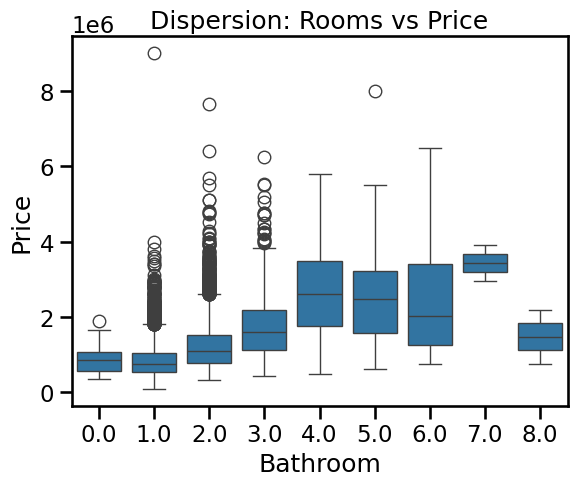

In [ ]:
# 2.  Mostrar la dispersión o distribución de las columnas seleccionadas.

ax = seaborn.boxplot(x='Bathroom', y='Price', data=result)
plt.title('Dispersion: Rooms vs Price')

ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

plt.show()

2025-05-20 20:24:04,533 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 20:24:04,535 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode where price < 1801000.0")
2025-05-20 20:24:04,536 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:24:04,536 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode where price < 1801000.0")
2025-05-20 20:24:04,538 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:24:04,539 INFO sqlalchemy.engine.Engine select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode where price < 1801000.0
2025-05-20 20:24:04,540 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:24:06,317 INFO sqlalchemy.engine.Engine ROLLBACK


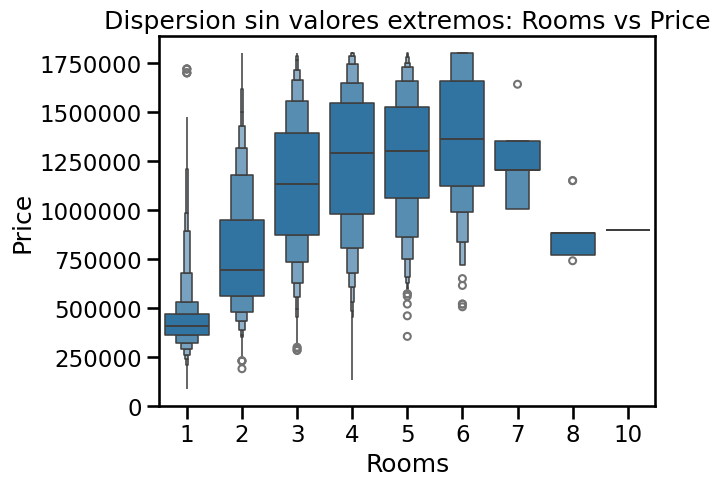

In [17]:
#Eliminar valores atípicos de propiedades con valores mayor a 6 millones y graficar

# Formateador para mostrar los precios en millones
def millones(x, pos):
    return f'{x * 1e-6:.1f}' # Added 'M' for clarity

formatter = FuncFormatter(millones)

pd.set_option('display.float_format', lambda x: '%.2f' % x)

queryJoin = "select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode"
resultJoin_unfiltered = pd.read_sql(queryJoin, con=engine)

# Calcula el cuantil en la columna 'Price' de los datos unidos sin filtrar
quantile = resultJoin_unfiltered['Price'].quantile(0.90)

# Filtra los datos unidos basándose en el cuantil calculado
resultJoin_filtered = resultJoin_unfiltered[resultJoin_unfiltered['Price'] < quantile].copy()

# Crear una figura con 1 fila y 4 columnas para los gráficos
fig, axes = plt.subplots(1, 4, figsize=(35, 10))  # Ajusta el figsize según sea necesario

# Gráfico Rooms vs Price en el primer subplot (índice 0)
resultJoin_filtered['Rooms'] = resultJoin_filtered['Rooms'].fillna(-1).astype(int).astype(str)
seaborn.boxenplot(x='Rooms', y='Price', data=resultJoin_filtered, ax=axes[0])
axes[0].yaxis.set_major_formatter(formatter) # Apply the 'millones' formatter
axes[0].set_title('Distribución sin valores extremos: Rooms vs Price')
axes[0].set_xlabel('Rooms')
axes[0].set_ylabel('Price (millions USD)')

# Gráfico Bedroom2 vs Price en el segundo subplot (índice 1)
seaborn.boxenplot(x='Bedroom2', y='Price', data=resultJoin_filtered, ax=axes[1])
axes[1].yaxis.set_major_formatter(formatter) # Apply the 'millones' formatter
axes[1].set_title('Distribución sin valores extremos: Bedroom2 vs Price')
axes[1].set_xlabel('Number of Bedrooms')
axes[1].set_ylabel('Price (millions USD)')


# Gráfico Bathroom vs Price en el tercer subplot (índice 2)
seaborn.boxenplot(x='Bathroom', y='Price', data=resultJoin_filtered, ax=axes[2])
axes[2].yaxis.set_major_formatter(formatter) # Apply the 'millones' formatter
axes[2].set_title('Distribución sin valores extremos: Bathroom vs Price')
axes[2].set_xlabel('Number of Bathrooms')
axes[2].set_ylabel('Price (millions USD)')

# Gráfico Regionname vs Price en el cuarto subplot (índice 3)
seaborn.boxenplot(x='Regionname', y='Price', data=resultJoin_filtered, ax=axes[3])
axes[3].yaxis.set_major_formatter(formatter) # Apply the 'millones' formatter
axes[3].set_title('Distribución sin valores extremos: Regionname vs Price')
axes[3].set_xlabel('Regionname')
axes[3].set_ylabel('Price (millions USD)')
axes[3].tick_params(axis='x', rotation=90)  # Rotar etiquetas del eje x para mejor visibilidad

plt.tight_layout()
plt.show()

2025-05-26 21:49:42,610 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-26 21:49:42,612 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select a.zipcode, count(*) as total from airbnb a inner join melb m on a.zipcode = m.Postcode group by a.zipcode having total > 1000")
2025-05-26 21:49:42,613 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:49:42,618 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select a.zipcode, count(*) as total from airbnb a inner join melb m on a.zipcode = m.Postcode group by a.zipcode having total > 1000")
2025-05-26 21:49:42,618 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:49:42,619 INFO sqlalchemy.engine.Engine select a.zipcode, count(*) as total from airbnb a inner join melb m on a.zipcode = m.Postcode group by a.zipcode having total > 1000
2025-05-26 21:49:42,619 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-26 21:49:43,275 INFO sqlalchemy.engine.Engine ROLLBACK
2025-05-26 21:49:43,275 INFO sqlalchemy.engine.Engin

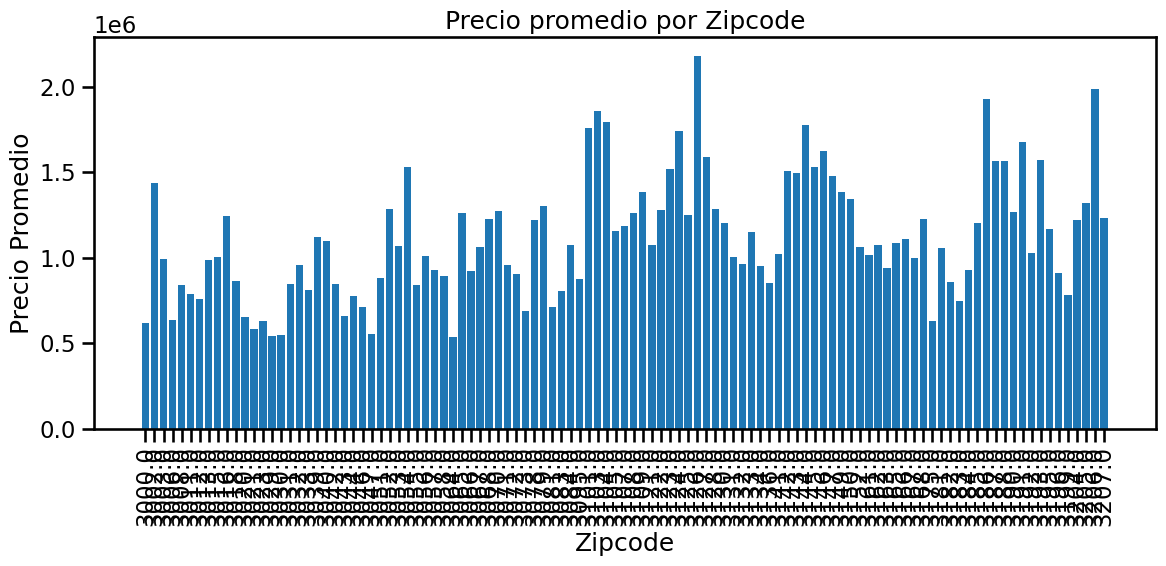

In [54]:
# Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico.
#   1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana (porque no la media?) o el mínimo.
#   2. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
#   3. Mostrar un gráfico zipcode vs airbnb_price_median. ()
#   4. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.
#   5. Si las coordenadas geoespaciales estuvieran disponibles, como las usarian?
queryZipCode = "select a.zipcode, count(*) as total from airbnb a inner join melb m on a.zipcode = m.Postcode group by a.zipcode having total > 1000"
resultJoin = pd.read_sql(queryZipCode, con=engine)
zipcodes = resultJoin['zipcode'].tolist()
zipcodes

queryZipCodeClear = "select * from melb m inner join airbnb a on a.zipcode = m.Postcode where a.zipcode in (" + ','.join(map(str, zipcodes)) + ")"	
resultqueryZipCodeClear = pd.read_sql(queryZipCodeClear, con=engine)
resultqueryZipCodeClear

# resultqueryZipCodeClear.groupby('zipcode').agg(
#     total=('Price', 'count'),
#     precio_promedio=('Price', 'mean'),
#     precio_median=('Price', 'median')
# ).reset_index().sort_values('total', ascending=False)

df_zipcode = resultqueryZipCodeClear.groupby('zipcode', as_index=False)['Price'].mean().rename(columns={'Price': 'precio_promedio'})

plt.figure(figsize=(12, 6))
plt.bar(df_zipcode['zipcode'].astype(str), df_zipcode['precio_promedio'])
plt.xlabel('Zipcode')
plt.ylabel('Precio Promedio')
plt.title('Precio promedio por Zipcode')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


-	Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. NO es necesario que realicen la implementación.
Si se contara con algún algoritmo capaz de encontrar ubicaciones cercanas a una propiedad se podría analizar la “accesibilidad al transporte público”, aspecto muy valorado al momento de alquilar o comprar una propiedad cuando no se posee un vehículo propio. Con esta información se podrían definir categorías como por ejemplo: "menos de 300m", "entre 300m y 1km", "más de 1km”. En general, las propiedades con mejor conectividad suelen tener mayor demanda y precios más altos.
Siguiendo bajo esta hipótesis, la “Distancia a x punto turístico” también sería relevante en el data set de AirBnB ya que generalmente al tratarse de alquileres temporales destinados a turismo suele ser un indicador clave de decisión al momento de elegir la propiedad, por lo tanto también incide en el precio de la propiedad
-	Si las coordenadas geoespaciales estuvieran disponibles, como las usarian?
Si las coordenadas geoespaciales estuvieran disponibles podrían utilizarse de diferentes maneras para mejorar la predicción de precios. Por ejemplo, podría usarse para calcular un precio promedio dentro de un radio determinado, lo cual ayudaría a comprender mejor la zona, contextualizando la propiedad en su entorno sin tener la limitación del CP o el barrio.
Además, las coordenadas permitirían calcular la distancia a diferentes puntos de interés, como escuelas, hospitales, puntos turísticos, entre otros. Esta información es muy valorada cuando se trata de alquileres temporarios ya que puede influir al momento de elegir el alojamiento. También puede ser clave al momento de tomar la decisión de comprar una propiedad, ya que se pueden visualizar los servicios disponibles y si es acorde al estilo de vida que desean los compradores.

-	¿Qué cosas no están en los datos que te gustaría tener para predecir mejor el precio de una propiedad?

El uso de coordenadas geográficas posibilitaría incorporar variables espaciales más ricas y precisas, mejorando tanto la segmentación como la predicción de precios en contextos urbanos. (REVISAR)


In [49]:
#5. Si las coordenadas geoespaciales estuvieran disponibles, como las usarian?
#en primer lugar, crearia un mapa para visualizar la ubicacion de las propiedades, junto con características de las mismas

import plotly.express as px
data = melb_df.sample(300)
fig = px.scatter_geo(
    data, lat=data.Lattitude, lon=data.Longtitude, color=data.Price,
    hover_name=data.Suburb,
    hover_data=['YearBuilt', 'Type', 'Rooms', 'Bathroom']
    )
fig.update_geos(fitbounds="locations")
fig.show()

In [54]:
# ejemplo: Calcular distancias a puntos de interés: Centro de la ciudad, Paradas de transporte público, Centros comerciales o parques

# Para calcular la distancia al centro de Melbourne

%pip install geopy
from geopy.distance import geodesic

# ejemplo: distancia al centro de Melbourne
melbourne_center = (-37.8136, 144.9631)
data['dist_to_cbd'] = data.apply(lambda row: geodesic((row['Lattitude'], row['Longtitude']), melbourne_center).km, axis=1)
# Mostrar las primeras filas del DataFrame con la nueva columna
print(data[['Suburb', 'Lattitude', 'Longtitude', 'dist_to_cbd']].head())

  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached geographiclib-2.0-py3-none-any.whl.metadata (1.4 kB)
Using cached geopy-2.4.1-py3-none-any.whl (125 kB)
Using cached geographiclib-2.0-py3-none-any.whl (40 kB)
Note: you may need to restart the kernel to use updated packages.
              Suburb  Lattitude  Longtitude  dist_to_cbd
1392  Brunswick West     -37.75      144.93         7.54
7673      Camberwell     -37.84      145.06         9.23
6967   Hawthorn East     -37.83      145.04         7.47
8030             Kew     -37.79      145.03         6.53
2182       Doncaster     -37.77      145.13        15.24


## Ejercicio 3:

Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas anteriormente.

## Ejercicios opcionales:

1. Armar un script en python (archivo .py) [ETL](https://towardsdatascience.com/what-to-log-from-python-etl-pipelines-9e0cfe29950e) que corra los pasos de extraccion, transformacion y carga, armando una funcion para cada etapa del proceso y luego un main que corra todos los pasos requeridos.

2. Armar un DAG en Apache Airflow que corra el ETL. (https://airflow.apache.org/docs/apache-airflow/stable/tutorial.html)

In [ ]:
resultJoin_filtered.to_sql('melb_airbnb_joined_filter', con=engine, if_exists='replace', index=False)
resultJoin.to_sql('melb_airbnb_joined_all', con=engine, if_exists='replace', index=False)
queryZipCodeClear.to_sql('melb_airbnb_zipcode', con=engine, if_exists='replace', index=False)
df_zipcode.to_sql('melb_airbnb_zipcode_avg', con=engine, if_exists='replace', index=False)

In [42]:
import pandas as pd
import datetime as dt
import requests
import io
from sqlalchemy import create_engine, text
import os
#from decouple import config
import logging

In [43]:
# En lugar de usar prints para ver el avance a medida que va corriendo el script se utilizan los logs.
# Los logs basicamente son registros que se van dejando para saber el codigo que ha sido ejecutado.
# Es decision arbitraria del programador decidir que desea registrar en los logs.
# En python se utiliza la libreria logging https://docs.python.org/3/library/logging.html#logging-levels
# La libreria permite definir niveles de logs (ERROR, DEBUG, INFO, etc). Segun la criticidad del error.
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [48]:

def extract(url,interesting_cols):
  # The extract process could be complex including some SQL queries
    if len(interesting_cols) ==0:
        df = pd.read_csv(url)
        logger.info('read_csv exitoso')
    else:
        df = pd.read_csv(url,usecols=interesting_cols)
        logger.info('read_csv exitoso con columnas interesantes')
    return df

def connection_db(database_name):
    '''Connect to DB using SQLAlchemy methods. Returns an engine created and connected'''
    try:
        engine = create_engine(f"sqlite:///{database_name}", echo=True)
        logger.info('Conexion exitosa a la base de datos')
        return engine

    except ValueError as e:
        logger.error(e)


def transform(df,database_table_name):
  '''Transform the data. In this case, we are going to use the same dataframe'''
  # En este caso no se realizan transformaciones
  # pero se pueden realizar transformaciones como eliminar columnas, renombrar columnas, etc.
  if database_table_name == 'melb' :
    melb_df['Postcode'] = pd.to_numeric(melb_df.Postcode, errors='coerce')
    melb_df['Postcode_int'] = melb_df.Postcode.fillna(0).astype('int') # Convertimos la columna Postcode a int y renombramos la columna para no perder la original
    melb_df['Date'] = pd.to_datetime(melb_df['Date'], errors='coerce') # Convertimos la columna Date a datetime
    melb_df['Bedroom2'] = melb_df['Bedroom2'].fillna(0).astype('int') # Convertimos la columna Bedroom2 a int
    melb_df['Bathroom'] = melb_df['Bathroom'].fillna(0).astype('int') # Convertimos la columna Bathroom a int
    melb_df['Car'] = melb_df['Car'].fillna(0).astype('int') # Convertimos la columna Car a int
  else:
    # Working data for the analysis
    airbnb_df['zipcode'] = pd.to_numeric(airbnb_df.zipcode, errors='coerce')
    airbnb_df['zipcode_int'] = airbnb_df.zipcode.fillna(0).astype('int') # Convertimos la columna zipcode a int y renombramos la columna para no perder la original
    airbnb_df['weekly_price_calculate'] = airbnb_df.apply(lambda row: row['price']*7. if pd.isnull(row['weekly_price']) else row['weekly_price'], axis=1) # Realizamos el calculo de weekly_price considerando price*7dias
    airbnb_df['monthly_price_calculate'] = airbnb_df.apply(lambda row: row['price']*30. if pd.isnull(row['monthly_price']) else row['monthly_price'], axis=1) # Realizamos el calculo de weekly_price considerando price*30dias


def save_database(df,table_name):
  '''Load the data into the database'''
  try:
      # Create a table 'melb' in the SQLite database
      df.to_sql(table_name, con=engine, if_exists='replace', index=False)
      logger.info('Carga exitosa de la tabla en la base de datos')
  except ValueError as e:
      logger.error(e)
      logger.error('Error en la carga de la tabla en la base de datos')
    

In [ ]:
# la funcion main es muy utilizada en scripts python cuando tenemos archivos .py por ejemplo etl.py
# al tener la funcion main pueden correr desde la terminal python etl.py y va a ejecutar lo definido en la funcion main
def main_etl():
    logger.info('Comienza la extraccion')
    logger.info('Conectar a la base de datos')
    engine = connection_db('melbourne.db')
    logger.info('Extract data from url melbourne dataset')
    df = extract('http://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv', [])
    logger.info('Transform data')
    transform(df,'melb')
    logger.info('Save data into database')
    save_database(df,'melb')
    logger.info('Extract data from url airbnb dataset')
    df = extract('http://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv', ['description', 'neighborhood_overview','street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode','price', 'weekly_price', 'monthly_price','latitude', 'longitude'])
    logger.info('Transform data')
    transform(df,'airbnb')
    logger.info('Save data into database')
    save_database(df,'airbnb')

if __name__ == "__main_etl__":
    logger.info('ETL Process Initialized')
    main_etl()

In [ ]:
# ejemplo de DAG en Airflow for melb ETL dataset
from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from datetime import datetime, timedelta
import pandas as pd
import logging

# Default args
default_args = {
    'owner': 'airflow',
    'retries': 1,
    'retry_delay': timedelta(minutes=5)
}

with DAG(
    'dag_melb',
    default_args=default_args,
    description='DAG ',
    schedule_interval=timedelta(hours=24),
    start_date=datetime(2025, 6, 26),
) as dag:
    connection = PythonOperator(task_id='engine',
                                python_callable=connection_db,
                                op_kwargs={'database_name': 'melbourne.db'},)
    extraction = PythonOperator(task_id='engine',
                                python_callable=extract,
                                op_kwargs={'url':'http://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv','interesting_cols':[]},)
    transformation = PythonOperator(task_id='transformation',
                                    python_callable=transform,
                                    op_kwargs={'database_table_name': 'melb'},)
    save_database_table = PythonOperator(task_id='save_database_table',
                                         python_callable=save_database,
                                        op_kwargs={'table_name':'melb'})
    connection >> extraction >> transformation >> save_database_table

# ejemplo de DAG en Airflow for airbnb ETL dataset

with DAG(
    'dag_airbnb',
    default_args=default_args,
    description='DAG ',
    schedule_interval=timedelta(hours=24),
    start_date=datetime(2025, 6, 26),
) as dag:
    connection = PythonOperator(task_id='engine',
                                python_callable=connection_db,
                                op_kwargs={'database_name': 'melbourne.db'},)
    extraction = PythonOperator(task_id='engine',
                                python_callable=extract,
                                op_kwargs={
                                    'url':'http://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv',
                                    'interesting_cols':['description', 'neighborhood_overview','street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode','price', 'weekly_price', 'monthly_price','latitude', 'longitude']},)
    transformation = PythonOperator(task_id='transformation',
                                    python_callable=transform
                                    op_kwargs={'database_table_name': 'airbnb'},)
    save_database = PythonOperator(task_id='save_database',
                                 python_callable=save_database,
                                 op_kwargs={'table_name':'airbnb'},)
    connection >> extraction >> transformation >> save_database